<a href="https://colab.research.google.com/github/joshuajhchoi/Real-Time-Voice-Cloning/blob/master/Vanilla_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Generative Adversarial Network : Hand's on lab Vanilla GAN/DCGAN

Instead of implementing a Vanilla GAN whose Generator and Discriminator are a simple feed-forward neural networks with a few hidden layer and since we will be dealing with Imagery data. We wanted to accomplish this practical with a more powerful network architecture such as Deep Convolution GAN, or [DCGAN](https://arxiv.org/abs/1511.06434). DCGAN and Vanilla GAN have the same setup the only diffrence is that DCGAN use CNNs.

CNNs have been phenomenal in computer vision tasks, be it for classifying images or detecting objects in images. CNNs were so good at understanding images that they inspired researchers to use CNNs in a GAN network. Initially, authors of the official GAN paper introduced Deep Neural Networks (DNNs) with dense layers only. Convolutional layers were not used in the original implementation of the GAN network. In the previous GANs, the generator and the discriminator network used dense hidden layers only. Instead, authors suggested that different neural network architectures can be used in a GAN setup.
DCGANs extend the idea of using convolutional layers in the discriminator and the generator network. The setup of a DCGAN is similar to a vanilla GAN. It consists of two networks: a generator and a discriminator. The generator is a DNN with convolutional layers, and the discriminator is a DNN with convolutional layers. Training a DCGAN is similar to training a vanilla GAN network.

# Why TensorFlow?

Even if there's a lot of alternatives like Torch, Caffe, Theano, Mxnet,.., [TensorFlow](https://www.tensorflow.org/) still has the largest community

[![alt text](https://drive.google.com/uc?export=view&id=1pxxGIAjMwf9I3c5yOt7ZqRiM2B_L8NLA)](https://opendatascience.com/deep-learning-with-tensorflow-2-pytorch/)

TensorFlow (TF) is an open source software library for numerical computation using the concept of Tensors. You can think of Tensors as being a generalisation of matrices to higher dimensions, or roughly equivalent to multi-dimensional arrays. Scalars are 0-dimensional tensors, vectors are 1-dimensional, standard matrices are 2-dimensional, and higher-dimensional tensors have 3 or more dimensions. You can think of dimensions as representing groups of numbers that mean the same thing. For example, for images, we often use 3-dimensional tensors where the first dimension represents the red, green, and blue color channels of the image, and the next two are the columns and rows of pixels of the image.

The major advantage of using TensorFlow is that it can automatically derive the gradients of many mathematical expressions involving tensors. It achieves this through a process called "automatic differentiation". Tensorflow also supports multiple "kernels", allowing you to easily run your code on normal processors (CPUs), graphics cards (GPUs) and other more exotic hardware accelerators like Google's Tensor Processing Units (TPUs)

### Introduction

The primary objective of the Generative Model is to learn the unknown probability distribution of the population from which the training observations are sampled from. Once the model is successfully trained, you can sample new, “generated” observations that follow the training distribution.

Developing a GAN for generating images requires both a discriminator convolutional neural network model for classifying whether a given image is real or generated and a generator model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values.

### Learning Objectives

- Define DCGAN and compare the diffrence between Vanilla GAN and DCGAN
- Explore the key concepts behind convolutional neural networks (CNNs).
- Gain experience implementing GANs by writing code for the generator, discriminator, and training loop.
- Learning New tricks to improve GANs
- To be able to explain loss functions and evaluate GANs performance
- Use the generator model to generate new images.

### Practical steps we will follow

1. Explore data and prepare the dataset for training
2. Define DCGAN and the major differences between Vanilla GAN and DCGAN
2. Have a global overview about CNNs
3. Implement Generator and discriminator architecture
4. Work on the training/ evaluation loop and generate new realistic samples using GANs


### Steps to run this notebook from Colaboratory

This colab will run much faster on GPU. To use a Google Cloud
GPU:

1. Go to `Runtime > Change runtime type`.
1. Click `Hardware accelerator`.
1. Select `GPU` and click `Save`.
1. Click `Connect` in the upper right corner and select `Connect to hosted runtime`.

### Imports (RUN ME!)

Make sure to run the imports cell above, otherwise the rest of the cells will fail when you try to run them. (To run a cell press `shift` + `enter` with your mouse cursor in the cell or press the play button in the top right of the cell.)

In [ ]:
%load_ext tensorboard
import os
from glob import glob
import time
import random

import IPython.display as display
import matplotlib.pyplot as plt # Matplotlib is used to generate plots of data.
import matplotlib.image as mpimg
import PIL
from PIL import Image
import imageio
import numpy as np # Numpy is an efficient linear algebra library.

import tensorflow as tf
from tensorflow.keras import layers
%matplotlib inline

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Configs

In [ ]:
# Experiment paths
# Save the model for further use
EXPERIMENT_ID = "train_3"
MODEL_SAVE_PATH = os.path.join("/content/drive/My Drive/lecture hands on lab/vanilla_gan_DCGAN/results", EXPERIMENT_ID)
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_DIR = os.path.join(MODEL_SAVE_PATH, 'training_checkpoints')

# Data path
DATA_PATH = "/content/drive/My Drive/lecture hands on lab/datasets/cars/cars_images/"

# Model parameters
BATCH_SIZE = 64
EPOCHS = 6000
LATENT_DEPTH = 100
IMAGE_SHAPE = [100,100]
NB_CHANNELS = 3
LR = 1e-4


# A fixed random seed is a common "trick" used in ML that allows us to recreate
# the same data when there is a random element involved.
seed = random.seed(30)

### Data understanding and exploration

It can be challenging to understand both how GANs work and how deep convolutional neural network models can be trained in a GAN architecture for image generation. A good starting point for beginners is to practice developing and using GANs on simple image datasets used in the field of computer vision. Using small and well-understood datasets means that smaller models can be developed and trained quickly, allowing focus to be put on the model architecture and image generation process itself.

We have choosen [cars dataset](https://www.kaggle.com/prondeau/the-car-connection-picture-dataset) from kaggle. It contains a lot of interior and useless images that was filtred to have 8960 diverse images with good quality ready to be used for training.

NB: with great model architecture and too little training data, GANs will overfit and will not easily converge.

In [ ]:
image_count = len(list(glob(str( DATA_PATH + '*.jpg'))))
image_count

8960

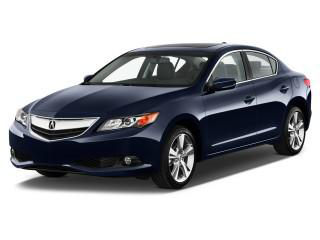

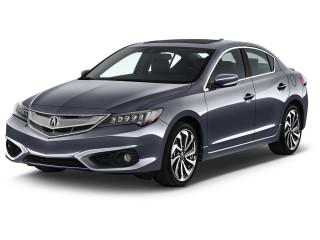

In [ ]:
cars_images_path = list(glob(str(DATA_PATH + '*.jpg')))
for image_path in cars_images_path[:2]:
    display.display(Image.open(str(image_path)))

In [ ]:
# Our goal to get images filenames
images_name = [i.split(DATA_PATH) for i in cars_images_path]
images_name = [x[:][1] for x in images_name]
cars_model = [i.split('_')[0] for i in images_name]

In [ ]:
# Extract cars models
def unique(list1): 
    list_set = set(list1) 
    unique_list = (list(list_set)) 
    return unique_list

In [ ]:
unique_cars = unique(cars_model)
unique_cars

['Volkswagen',
 'smart',
 'Audi',
 'Nissan',
 'Rolls-Royce',
 'Acura',
 'Subaru',
 'Tesla',
 'Chevrolet',
 'Aston Martin',
 'Chrysler',
 'Toyota',
 'Buick',
 'Volvo',
 'Porsche',
 'BMW',
 'Alfa Romeo',
 'Cadillac',
 'Ram',
 'Bentley']

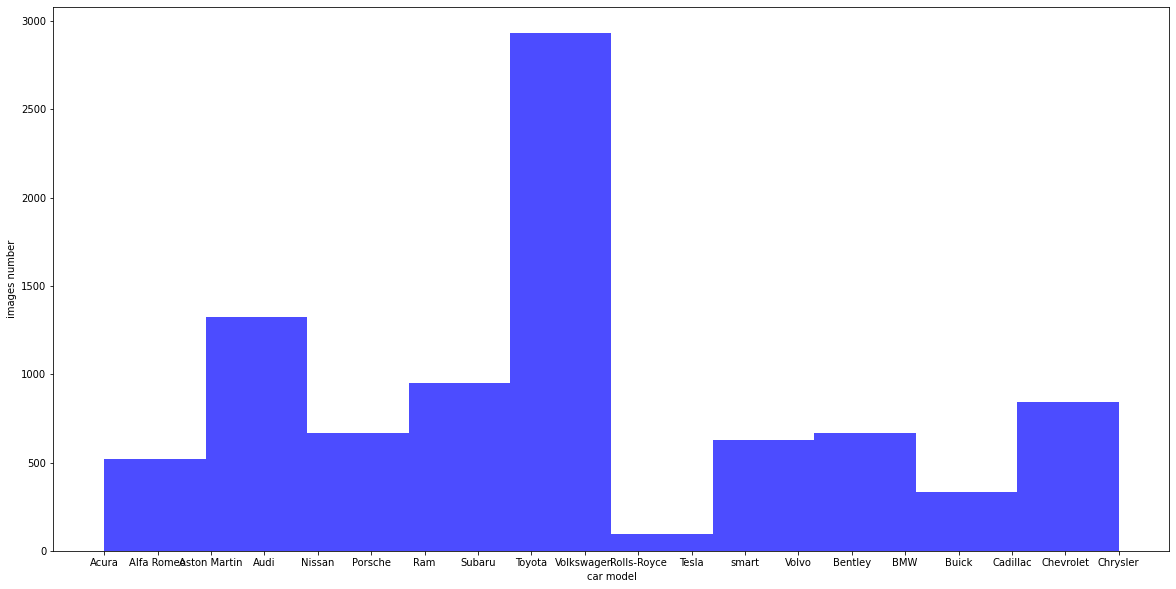

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(cars_model, color = "blue", lw=0, alpha=0.7)
plt.ylabel('images number')
plt.xlabel('car model')
plt.show()

In [ ]:
image_size = []
for filename in cars_images_path:
    im=Image.open(filename)
    im =im.size
    image_size.append(im)
print(max(image_size))
print(min(image_size))

(320, 360)
(320, 124)


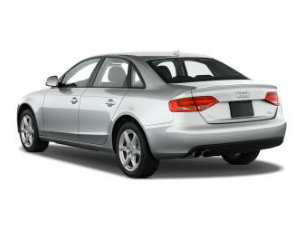

In [ ]:
# Read in the image
image = mpimg.imread(cars_images_path[20])

plt.axis("off")
plt.imshow(image)

##### Let's take a look on the different channel axis views of the image (the red, green and blue channels)

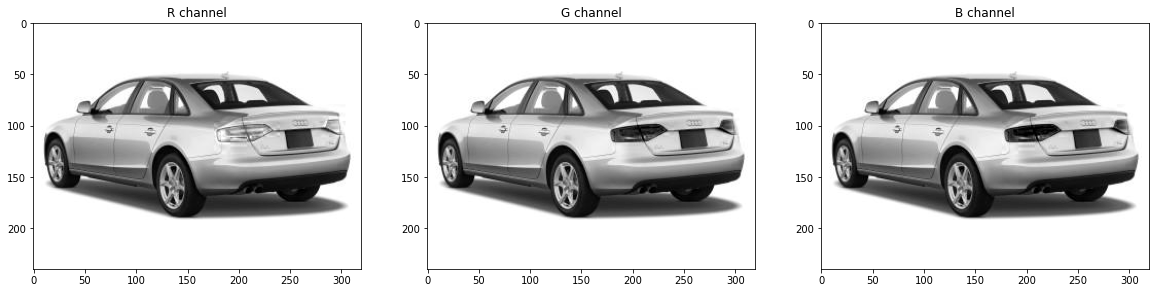

In [ ]:
# Isolate RGB channels
r = image[:,:,0]
g = image[:,:,1]
b = image[:,:,2]

# Visualize the individual color channels
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('R channel')
ax1.imshow(r, cmap='gray')
ax2.set_title('G channel')
ax2.imshow(g, cmap='gray')
ax3.set_title('B channel')
ax3.imshow(b, cmap='gray')

The dataset contains 8960 images:
* Three-channel each one.
* Diverse styles
* The minimum shape is (320, 124)
* The maximum shape is (320, 360)

### Data Loader

For the Data pipeline, I will show you two versions. The first one will be using Data API provide it by TensorFlow. What we have to do is create a dataset object, tell it where to get the data, then transform it in any way we want, and TensorFlow takes care of all the implementation details, such as multithreading, queuing, batching, prefetching, and so on.\
(1) Create dataset entirely in RAM using tf.data.Dataset.from_tensor_slices() \
(2) Call shuffle to ensure that the training set are independent and identically distributed. \
NB:  the buffer size must be specified, and it is important to make it large enough or else shuffling will not be very efficient.\
(3) Do the necessary transformation by calling the map() method. \
(4) Call the batch() method. It will group the items of the previous dataset in batches of n items. \
(5) Using prefetch will let the dataset work on parallel with training algorithm to get the next batch ready.
![alt text](https://drive.google.com/uc?export=view&id=1xe7O6sTg1HxbM_Fc8p57gGXB9keeaDjC)

The second version will be using PIL to read the image and do the resizing. The main differences are:
- PIL is time-consuming. It takes multiple 4 the time it takes Tensorflow.
- PIL is the best in keeping image quality while resizing the image. Because The `resize()` function doesn't modify the used image, it instead returns another Image with the new dimensions.

In production, we sometimes sacrifice the quality and tend to get results more quickly. Eventually, we will have the quality but after tunning and many experiences.

We must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [-1,1] or [0,1]. But you should know that if you're using [-1,1] you need to choose tanh as an activation function and if you are normalizing to [0,1] you use sigmoid activation function.

### Data Loader using TF API

In [ ]:
@tf.function
def preprocessing_data(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SHAPE[0],IMAGE_SHAPE[1]])
    image = image / 255.0
    return image

In [ ]:
def dataloader(paths):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.shuffle(10* BATCH_SIZE)
    dataset = dataset.map(preprocessing_data)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
dataset = dataloader(cars_images_path)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

### Data Loader using PIL

In [ ]:
image_list = []
for filename in cars_images_path:
    im=Image.open(filename)
    im =im.resize((IMAGE_SHAPE[0],IMAGE_SHAPE[1]))
    image_list.append(im)

In [ ]:
images_processed = []
for image in image_list:
    gan_train_images = np.asarray(image)
    gan_train_images = gan_train_images.astype('float32') /255.0
    images_processed.append(gan_train_images)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(images_processed).shuffle(10* BATCH_SIZE).batch(BATCH_SIZE)
for batch in dataset.take(1):
    for img in batch:
        img_np = img.numpy()
        plt.figure()
        plt.axis('off')
        plt.imshow((img_np-img_np.min())/(img_np.max()-img_np.min()))

# Modeling


In this notebook we will use Deep Convolution GAN, [DCGAN](https://arxiv.org/abs/1511.06434). The Generator and Discriminator will use convolutional and transpose convolutional layers. The generator will have as input noise and output a tensor of a shape (batch_size, image_shape[0], image_shape[1], 3) and **3** refers to `three channels: Red, Green, and Blue (RGB)`. The discriminator will have as input image with the same shape as generator output once real image and once fake one and output it's decision. 

![alt text](https://drive.google.com/uc?export=view&id=1-DCVW5uNn_UbcwQugEaB1YG-fnL6-wmY)

                                We will need to increase and decrease the image dimensions !!!

## Let's Explain briefly the relationship between convolutional layers and transposed convolutional layers.

#### CNNs main building blocks:
* The input
* The Kernel is the shaded area in the picture bellow of value slides across the input feature map to extract from each location the product between each element of the kernel and the input element. The final outputs of this procedure are called output feature maps.
* Stride (distance between two consecutive positions of the kernel) 
* Zero padding (number of zeros concatenated at the beginning and at the end of an axis)
* Pooling operations reduce the size of feature maps by using some function to summarize subregions, such as taking the average or the maximum value.
[![Screenshot%20from%202020-07-28%2016-24-23.png](https://drive.google.com/uc?export=view&id=1Fs5yg7P3Zd2l0g8hfa8K0-qBJxwQ7iHk)](https://arxiv.org/pdf/1603.07285.pdf)

The size of the output will be equal to the number of steps made, plus one, accounting for the initial position of the kernel, considering that the kernel starts on the leftmost part of the input feature map and slides by steps of one until it touches the right side of the input with stride 1 and without padding.

[![Convolution_arithmetic_-_No_padding_no_strides.gif](https://drive.google.com/uc?export=view&id=1-46jMj3NfJRkOkkAkjlwcLME_CETPvz7)](https://github.com/vdumoulin/conv_arithmetic)

[![YyCu2.gif](https://drive.google.com/uc?export=view&id=1-8UWADYXK31vHzkzfgsMF5jQO-Utevod)](https://github.com/vdumoulin/conv_arithmetic)
                            Blue refers to input and green refers to ouput

The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some  convolution to something that has the shape of its input while maintaining a connectivity pattern.
The transposed convolution used in image segmentation , generative models , and decoders. \
To deep dive more take a look on those amazing ressources [A guide to convolution arithmetic for deep
learning](https://arxiv.org/pdf/1603.07285.pdf) and [Is the deconvolution layer the same as a convolutional layer?](https://arxiv.org/pdf/1609.07009.pdf)

### Generator

The generator model is responsible for creating new, fake, but plausible small photographs of objects.
It does this by taking a point from the latent space as input and outputting a square color image.

The latent space is an arbitrarily defined vector space of [Gaussian-distributed values](https://machinelearningmastery.com/statistical-data-distributions/), e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space.

- Inputs: Points in latent space, e.g. a 100-element vector of Gaussian random numbers.
- Outputs: Two-dimensional square color image (3 channels) of 100 x 100 pixels with pixel values in [0,1].

Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but this is a parameter that can be changed from problem to problem.

![Generator.png](https://drive.google.com/uc?export=view&id=1R14EtpJXZo_kKWJSsUqUPPdLgZ_phMhV)


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*25*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((25, 25, 128)))
    assert model.output_shape == (None, 25, 25, 128) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 25, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 50, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 100, 100, 3)
    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80000)             8000000   
_________________________________________________________________
batch_normalization (BatchNo (None, 80000)             320000    
_________________________________________________________________
re_lu (ReLU)                 (None, 80000)             0         
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 25, 25, 128)       409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 25, 128)       512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 25, 25, 128)       0

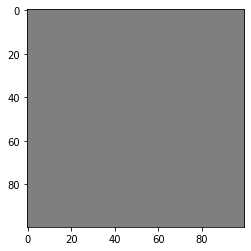

In [ ]:
generator = make_generator_model()
noise = tf.random.normal([1, LATENT_DEPTH])
generated_image = generator(noise, training=True)

plt.imshow(generated_image[0, :, :, :], cmap='gray')

### Discriminator

The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake. This is a binary classification problem.

- Inputs: Image with three color channel and 100×100 pixels in size.
- Outputs: Binary classification, likelihood the sample is real (or fake).

The model is trained to minimize [the binary cross entropy loss function](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/), appropriate for binary classification.
![Discriminator.png](https://drive.google.com/uc?export=view&id=1AUwLeBvtGLnnoMx6m-xXi9Aq4LuQjaOp)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[100, 100, 3]))
    model.add(layers.ReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    model.summary()
    return model

2×2 stride acts to down-sample the input image, first from 100×100 to 50×50, then to 25×25 before the model makes an output prediction.

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        4864      
_________________________________________________________________
re_lu_3 (ReLU)               (None, 50, 50, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
re_lu_4 (ReLU)               (None, 25, 25, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 25, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 80000)            

## Training Process
#### MiniMax game
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
To optimize this minimax game, we will aternate between taking gradient descent steps on the objective for $G$, and gradient ascent steps on the objective for $D$:

* Update the generator ($G$) to minimize the probability of the discriminator making the correct choice.
$$\underset{G}{\text{minimize}}\;\mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
* Update the discriminator ($D$) to maximize the probability of the discriminator making the correct choice.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the discriminator making the incorrect choice. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the [original paper](https://arxiv.org/abs/1406.2661)
Here, We will alternate the following updates:

* Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
* Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### Loss and Optimization

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(lr=LR)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=LR) 

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Experiment utils (RUN ME!)

In [ ]:
def summary(name_data_dict,
            step=None,
            types=['mean', 'std', 'max', 'min', 'sparsity', 'histogram'],
            historgram_buckets=None,
            name='summary'):
    """Summary.
    Examples
    --------
    >>> summary({'a': data_a, 'b': data_b})
    """
    def _summary(name, data):
        if data.shape == ():
            tf.summary.scalar(name, data, step=step)
        else:
            if 'mean' in types:
                tf.summary.scalar(name + '-mean', tf.math.reduce_mean(data), step=step)
            if 'std' in types:
                tf.summary.scalar(name + '-std', tf.math.reduce_std(data), step=step)
            if 'max' in types:
                tf.summary.scalar(name + '-max', tf.math.reduce_max(data), step=step)
            if 'min' in types:
                tf.summary.scalar(name + '-min', tf.math.reduce_min(data), step=step)
            if 'sparsity' in types:
                tf.summary.scalar(name + '-sparsity', tf.math.zero_fraction(data), step=step)
            if 'histogram' in types:
                tf.summary.histogram(name, data, step=step, buckets=historgram_buckets)

    with tf.name_scope(name):
        for name, data in name_data_dict.items():
            _summary(name, data)

In [ ]:
train_summary_writer = tf.summary.create_file_writer(os.path.join(MODEL_SAVE_PATH, 'summaries', 'train'))
checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_and_save_images(model, epoch):
    
    plt.figure(figsize=(15,10))

    for i in range(4):
        noise = tf.random.normal([1,100])
        images = model(noise, training=False)
        
        image = images[0, :, :, :]
        image = np.reshape(image, [100, 100, 3])

        plt.subplot(1, 4, i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.title("Randomly Generated Images")

    plt.tight_layout()  
    plt.savefig(os.path.join(MODEL_SAVE_PATH,'image_at_epoch_{:02d}.png'.format(epoch)))
    plt.show()

### Model Traning

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DEPTH])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return {'Generator loss': gen_loss,
            'Discriminator loss': disc_loss}

In [ ]:
def train(dataset, epochs):
    with train_summary_writer.as_default():
        with tf.summary.record_if(True):
            for epoch in range(epochs):
                start = time.time()

                for image_batch in dataset:
                    loss_dict = train_step(image_batch)
                summary(loss_dict, step=generator_optimizer.iterations, name='losses')
                # Save the model every 15 epochs
                if (epoch + 1) % 15 == 0:
                    checkpoint.save(file_prefix = checkpoint_prefix)
                    display.clear_output(wait=True)
                    generate_and_save_images(generator,
                                             epoch + 1)
                print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs)

In [ ]:
%tensorboard --logdir='/content/drive/My Drive/lecture hands on lab/vanilla_gan_DCGAN/results/train_3/summaries/train'

In [ ]:
train(dataset, EPOCHS)

 ### Generate Gif with the whole generated images during training

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob(os.path.join(MODEL_SAVE_PATH, 'image*.png'))
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)


# Congratulations!
you have built your first DCGAN

### Suggestion tasks for practice

* Play arround with the model architecture
* Play arround with optimizer
* Tuning the hyperparameters
  - Learning rate
  - Batch size
  - Number of epochs
  - Generator optimizer
  - Discriminator optimizer
  - Number of layers
  - Number of units in a dense layer
  - Activation function
* Observe the discriminator and generator loss failure and image generation failure using tensorboard
* See this [github](https://github.com/soumith/ganhacks) repo that contains a set of 17 hacks that are useful for getting models working

#### Extra Reading and References :

* https://developers.google.com/machine-learning/gan/generator
* https://github.com/divyanshj16/GANs/blob/master/GANs-TensorFlow.ipynb
* https://github.com/vdumoulin/conv_arithmetic
* https://arxiv.org/abs/1603.07285

### Practical Applications

* Generate your own drawing board
* Generate your car, clothes or any object style
* Augmenting dataset
* Human face generation
* Feature extraction
